In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import Tensor

In [4]:
""" set the torch device to mps for using gpu cores in macOS """

# set the accelerator platform
# mps: macOS GPU platform
os = "macOS"
accelerator = None
if os == "macOS": accelerator = "mps" if torch.backends.mps.is_available() else "cpu"
elif os == "linux": accelerator = 'cuda:0' if torch.cuda.is_available() else 'cpu'

device = torch.device(accelerator)
print(f"current accelerator is: {device}")

current accelerator is: mps


In [73]:
""" experiment code for checking the "blessing of dimension"
1) l2 norm of vectors
    - latent space 차원이 커질수록, 벡터의 길이가 증가하는 것은 맞음
    - 그런데 차원이 커질수록, 벡터의 길이가 평준화 되는 경향 존재, norm.max()/norm.min() 비율이 점점 감소

2) angle of two different vectors
    - cos theta = torch.matmul() / l2normalization
    - except for self-dot

3) distance of two different vectors
"""

max_seq = 512
hidden_dim = 64
x = torch.randn(max_seq, hidden_dim)

l2 = x.norm(dim=-1)
print(f"L2 norm of vectors, breakdown by latent vector space of word embedding: {l2}")

L2 norm of vectors, breakdown by latent vector space of word embedding: tensor([6.8651, 7.2179, 6.7625, 8.7043, 9.0959, 7.7101, 8.1310, 8.8149, 7.3182,
        8.2651, 8.8454, 7.2061, 8.3703, 8.9787, 9.7458, 6.4056, 8.6399, 8.4984,
        6.8564, 7.9275, 8.7333, 6.3276, 7.5210, 7.0615, 7.5958, 7.9502, 6.6438,
        8.0365, 7.2607, 8.1379, 8.6508, 8.1294, 9.2185, 9.0047, 8.1197, 8.1145,
        8.1066, 8.3894, 6.9582, 8.9986, 6.9306, 7.3476, 7.7750, 7.8299, 8.6920,
        7.9953, 8.7776, 7.8020, 6.9227, 8.0564, 7.0644, 7.7895, 8.4040, 7.5747,
        8.2878, 7.9805, 8.0366, 7.9437, 7.5142, 7.7369, 9.4430, 7.4196, 6.9771,
        7.6923, 8.3263, 7.3074, 7.9013, 8.3454, 8.8384, 8.8121, 8.0227, 7.6881,
        7.3712, 6.6919, 7.7855, 8.3439, 7.1703, 8.6071, 7.1170, 6.5966, 7.3433,
        8.6284, 8.3496, 8.3399, 8.2506, 7.0133, 8.5117, 7.7981, 6.8637, 7.9650,
        7.5006, 7.9366, 7.3016, 7.7798, 8.5138, 7.1274, 7.1523, 7.7967, 8.6530,
        7.4607, 8.4890, 9.1109, 7.6658, 8.4866, 

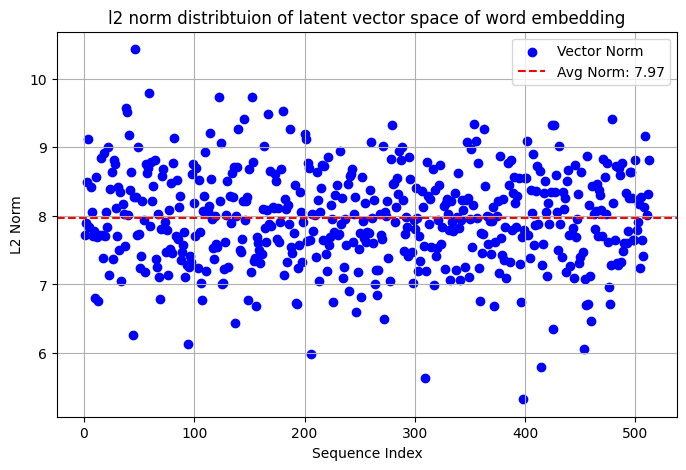

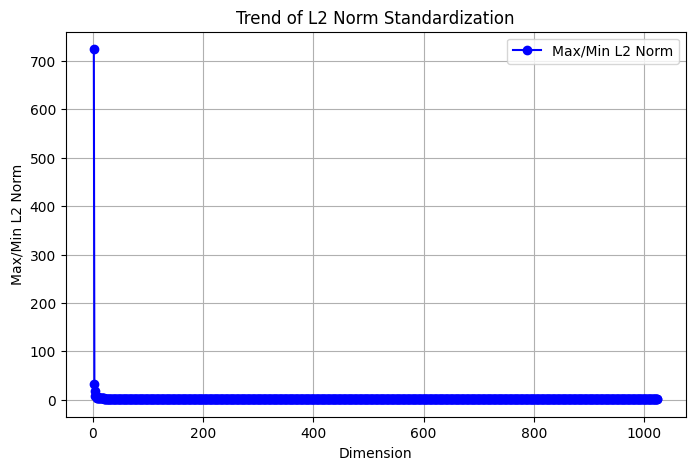

In [71]:
def plot_vector_norm(norms: Tensor):
    """ helper func for visualizing the vector norm
    Args:
        norms: tensor of vector norms
    """
    plt.figure(figsize=(8, 5))
    plt.scatter(range(1, max_seq + 1), norms, color='b', label='Vector Norm')
    plt.axhline(y=norms.mean(), color='r', linestyle='--', label=f'Avg Norm: {norms.mean():.2f}')
    plt.xlabel('Sequence Index')
    plt.ylabel('L2 Norm')
    plt.title('l2 norm distribtuion of latent vector space of word embedding')
    plt.legend()
    plt.grid()
    plt.show()

def plot_norm_standardization():
    """ helper func for plotting the norm standardization phenomenon
    """
    l2_list = []
    max_seq = 512
    for d in range(2, 1025):
        x = torch.randn(max_seq, d)
        l2 = x.norm(dim=-1)
        l2_list.append(l2.max() / l2.min())

    plt.figure(figsize=(8, 5))
    plt.plot(range(2, 1025), l2_list, marker='o', linestyle='-', color='b', label='Max/Min L2 Norm')
    plt.xlabel('Dimension')
    plt.ylabel('Max/Min L2 Norm')
    plt.title('Trend of L2 Norm Standardization')
    plt.legend()
    plt.grid()
    plt.show()


# check the l2 norm of vectors, breakdown by latent vector space of word embedding
plot_vector_norm(l2)
plot_norm_standardization()

In [131]:
""" theta distribution of latent vector space of word embedding
between two different vectors
"""

# calculate the cos theta of two different vectors
def compute_angles(max_seq=64, hidden_dim=hidden_dim):
    """ helper func for calculating the the angle between two different vectors in latent space of word embedding
    """
    x = torch.randn(max_seq, hidden_dim, device=device)
    x_norm = x / x.norm(dim=-1, keepdim=True)
    cos_theta = torch.matmul(x_norm, x_norm.T)
    theta_rad = torch.arccos(torch.clamp(cos_theta, -1.0, 1.0))
    theta_deg = torch.rad2deg(theta_rad)
    return theta_deg.cpu()

def flatten_without_diag(x: Tensor):
    """ helper func for masking the diagonal element in matrix
    this func use for visualizing the angle between two different vectors in latent space of word embedding
    """
    # aliasing the tensor dimension
    max_seq, dim_model = x.size()

    # make the mask for diagonal element in matrix
    mask = torch.ones_like(x, dtype=torch.bool)
    diag_indices = torch.arange(min(max_seq, dim_model))
    mask[diag_indices, diag_indices] = False
    return x[mask].flatten()

# plotting the angle of two different vectors
def plot_angle_vector(vectors: torch.Tensor):
    """
    Args:
        vectors (torch.Tensor): must be 1D flattened tensor of angle

    Reference:
        - https://pytorch.org/docs/stable/generated/torch.triu.html
    """
    if vectors.dim() != 1:
        raise ValueError("Input tensor must be 1-dimensional.")

    plt.figure(figsize=(8, 5))
    plt.scatter(range(len(vectors)), vectors, color='b', alpha=0.6, edgecolors='k', label="Angle Values")
    plt.xlabel("Index")
    plt.ylabel("Angle (degrees)")
    plt.title("Scatter Plot of Angle Vectors")
    plt.legend()
    plt.grid(True)
    plt.show()

theta_matrix = compute_angles()
theta_matrix

tensor([[1.9782e-02, 8.6961e+01, 1.0458e+02,  ..., 9.7327e+01, 8.6726e+01,
         9.6861e+01],
        [8.6961e+01, 2.7976e-02, 9.4678e+01,  ..., 7.7742e+01, 8.7209e+01,
         7.7669e+01],
        [1.0458e+02, 9.4678e+01, 0.0000e+00,  ..., 9.1097e+01, 1.0476e+02,
         1.0037e+02],
        ...,
        [9.7327e+01, 7.7742e+01, 9.1097e+01,  ..., 0.0000e+00, 8.8181e+01,
         7.9493e+01],
        [8.6726e+01, 8.7209e+01, 1.0476e+02,  ..., 8.8181e+01, 4.4235e-02,
         9.4890e+01],
        [9.6861e+01, 7.7669e+01, 1.0037e+02,  ..., 7.9493e+01, 9.4890e+01,
         3.9565e-02]])

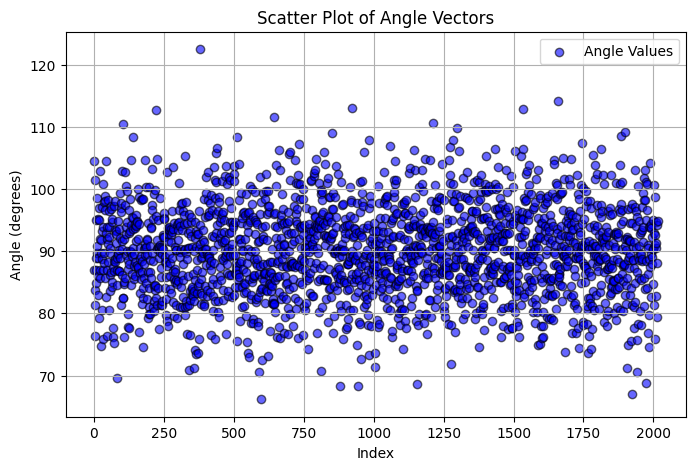

In [132]:
# get theta vectors of two different vectors from word embedding
# masking for self-dot angle

theta_vector = theta_matrix.triu(diagonal=1)
theta_vector = flatten_without_diag(theta_vector)
thetas = theta_vector[theta_vector > 0.0]
plot_angle_vector(thetas)
